<a href="https://colab.research.google.com/github/jonathannghj/PyTorch-Deep-Learning/blob/main/01_pytorch_workflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow
Exploring an example of PyTorch end-to-end workflow.

In [ ]:
what_we_are_covering = {1: "data (prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading model",
                        6: "putting it all together"
                        }

In [ ]:
import torch
from torch import nn # nn contains all the building blocks to build neural network
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu118'

## 1. Data (Preparing and loading)
Data can be almost anything... in ML
* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine Learning is a game of 2 parts
1. Get data into numerical representation
2. Build a model to learn patterns 

To showcase this, use linear regression with known parameters

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

# slice operator : [a,b] means from [a,b)
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [ ]:
### Splitting data into training and test sets (most important concept)

In [ ]:
# create a train test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],  y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
# visualise the data?
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data= X_test,
                     test_labels=y_test,
                     predictions= None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, color = "blue", s = 4, label = "Training data")
  
  plt.scatter(test_data, test_labels, c="g", s=4, label = "Test data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s = 4, label = "Predictions")

  plt.legend(prop={"size": 14})
  

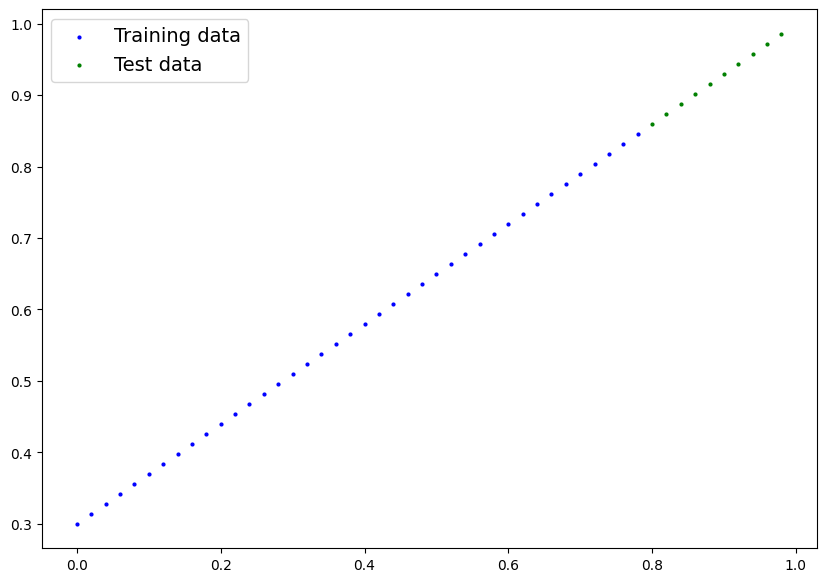

In [ ]:
plot_predictions()

## 2. Build Model

What our model does:
* start with random values (weight & bias)
* look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and biases we used to create the data)

How does it do so?
Through two main algorithms:
1. Gradient Descent # requires_grad=True
2. Backpropagation

In [ ]:
from torch import nn

class LinearRegressionModel(nn.Module): # nn.Module : everything in PyTorch imports from nn.Module (ancestor class) models should also subclass its class
  def __init__(self):
    super().__init__()

    # random weights and biases, through the forward propagation, it will determine the optimal weight and bias

    self.weights = nn.Parameter(torch.randn(1, 
                                           requires_grad=True,
                                           dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # Forward Propagation to define the computation in the model at every call, overridden by all subclasses (our nn class) MUST
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" <- is the input data
    return self.weights * x + self.bias







### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs
* torch.nn.Parameter - what parameters our model try to learn, often a PyTorch later from torch.nn will set these up for us
* torch.nn.Module - The base class for all nn modules, if subclass it, should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.module subclasses require you to overwrite this 

 ### Checking the contents of our PyTorch Model

 use .parameters(). to check what the parameters are

In [ ]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
model_0

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# a better way is to use the named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
weight, bias

(0.7, 0.3)

### Making predictions using torch.inference_mode()

To check our model's predictive power, let's see how it predicts the labels (y_test) based on inputs (X_test)

When we pass data through our model, it is going to run using the forward method.

In [ ]:
# NotImplementedError
# Make predictions with model
with torch.inference_mode(): # context manager. torch uses this. why use this? it turns off that gradient tracking. During inference, no need to use during gradient tracking that is used during training, using lesser computational power. can use torch.no_grad(), however, inference_mode() is preferred
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

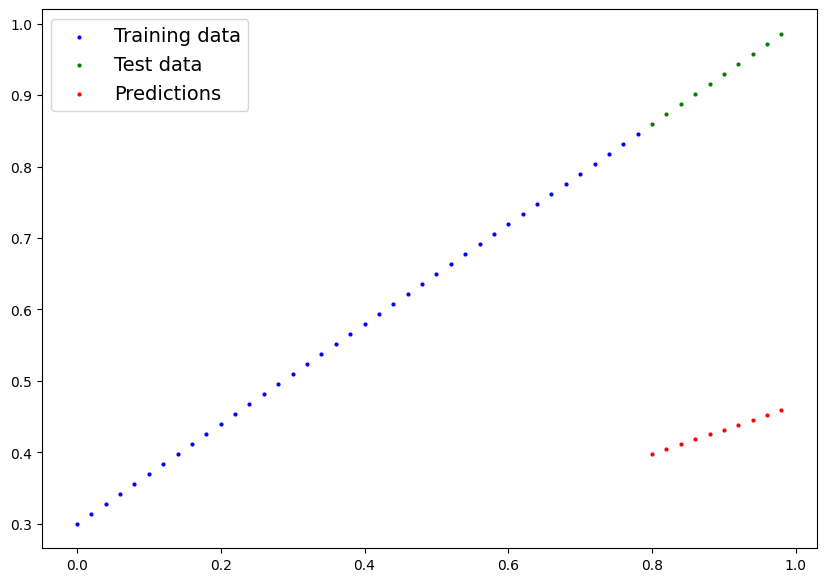

In [ ]:
plot_predictions(predictions = y_preds)

## 3. Train Model 
Move from some unknown parameters -> known, poor -> good

One way to measure how poor/how wrong is to use a loss function

Loss Function/Criterion: A function to measure how wrong the model's predictions are to the ideal outputs.

Optimizer: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias)

In the optimizer, need to set two parameters
1. params - model parameters you would like to optimize, e.g params=model_0.parameter()
2. lr (learning rate) - how big/small the optimizer takes with each step

And for PyTorch, we need:
* Training Loop
* Testing Loop


Which loss function and optimizer to use? 
* problem-specific. E.g. regression -> nn.L1Loss(), torch.optim.SGD() will do, but for classification of 2 classes, need nn.BCELoss() (binary cross entropy loss)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:

# L1 Loss: Mean Absolute Error
# Setup a loss function
loss_fn = nn.L1Loss()

# Stochastic gradient Descent (random gradient descent)
# Setup an optimiser
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr is the most important hyperparameter ensures that the changes in the weight is kept optimal, too small -> too long, too large -> may overshoot the global optimum

In [ ]:
loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data and do:
1. Forward pass/propagation to make predictions(this involves data moving forward using the forward() function)
2. Calculate loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - Move backwards through the nn to calculate the gradients of each of the parameters of our model with respect to loss (**Backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)
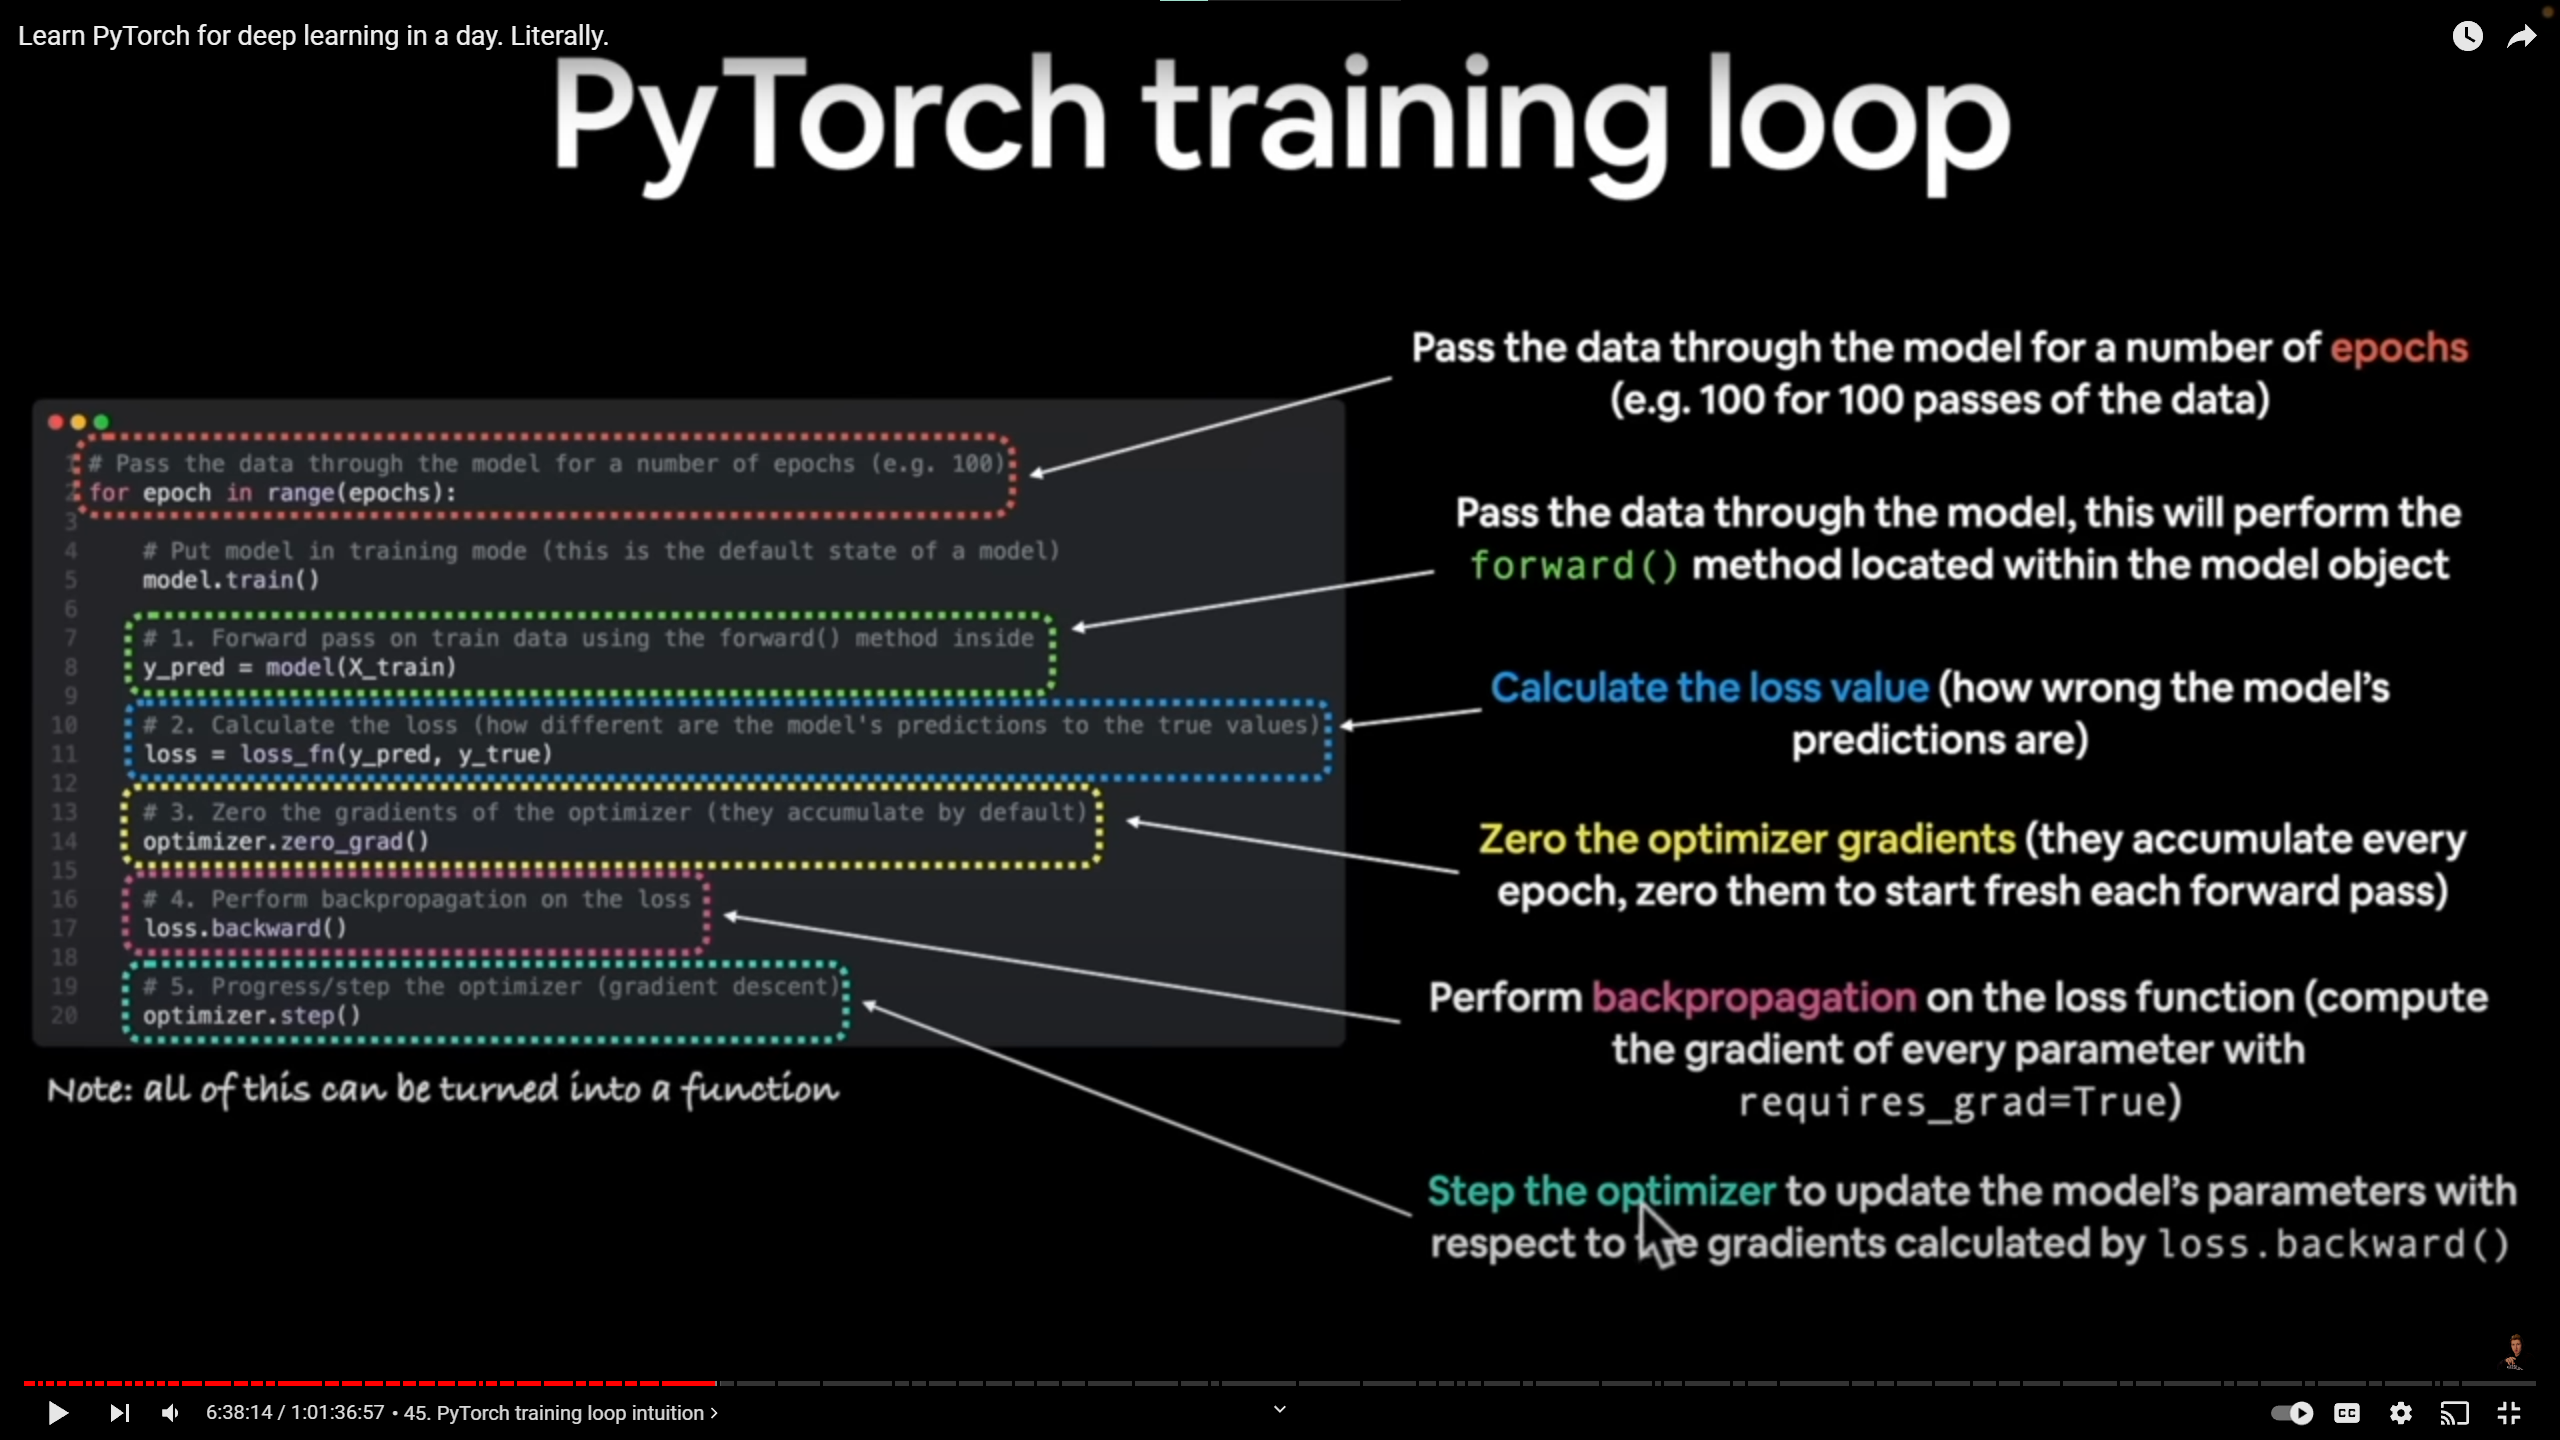

In [ ]:
# An epoch is one loop through the data epoch is a hyperparameter since we set it ourselves
epochs = 200

# Tracking different values of current model vs new model
epoch_count = []
loss_values = []
test_loss_values = []

### Training 
# 0. Loop through the data
for epoch in range (epochs):
  # Set the model to training mode
  model_0.train() # train mode in Pytorch sets all parameters that require 
  model_0.eval() # turns off gradient tracking

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)
  print(f"{loss}")
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumuate through the loop... so we have to zero them in step 3 during the next iteration
 
  ### Testing
  model_0.eval() # turns off gradient tracking & different settings in the model not needed for evaluation
  
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # 1. Do forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  # Status Update
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

    print(model_0.state_dict())


0.31288138031959534
Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
0.3013603389263153
0.28983935713768005
0.2783183455467224
0.26679736375808716
0.2552763521671295
0.24375534057617188
0.23223432898521423
0.22071333229541779
0.20919232070446014
0.1976713240146637
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
0.18615034222602844
0.1746293306350708
0.16310831904411316
0.1515873372554779
0.14006635546684265
0.1285453587770462
0.11702437698841095
0.1060912236571312
0.09681284427642822
0.08908725529909134
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
0.08227583020925522
0.07638873159885406
0.07160007208585739
0.06747635453939438
0.06395438313484192
0.06097004935145378
0.05845819041132927
0.05635259300470352

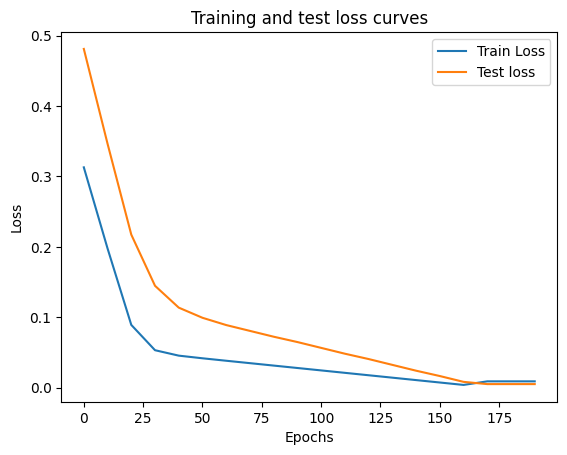

In [ ]:
import numpy as np
# Plot the loss curves
# Note: Since matplotlib only works with numpy, need to use np.array(torch.tensor(loss_values).cpu().numpy())
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
with torch.inference_mode(): # context manager. torch uses this. why use this? it turns off that gradient tracking. During inference, no need to use during gradient tracking that is used during training, using lesser computational power. can use torch.no_grad(), however, inference_mode() is preferred
  y_preds_new = model_0(X_test)

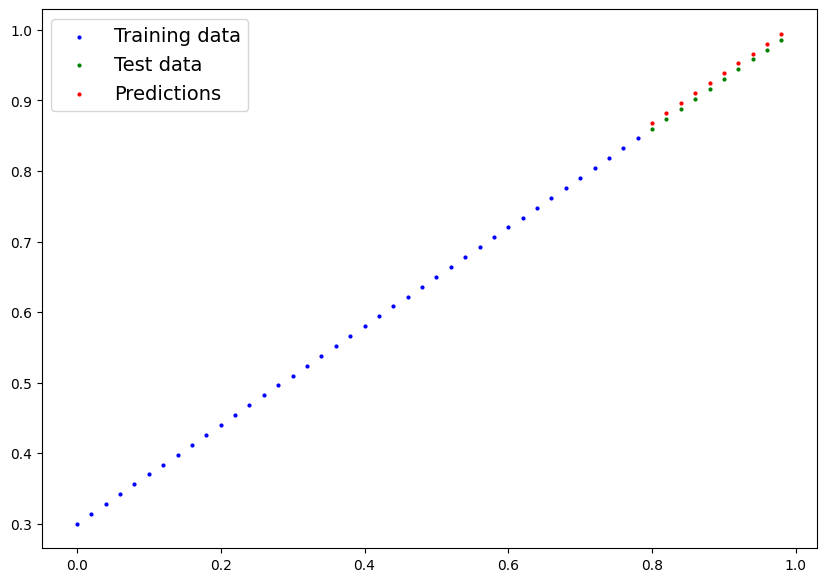

In [ ]:
plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

3 main methods for saving and loading

1. 'torch.save()' - save a PyTorch object in pickle format binary protocol

2. 'torch.load()' - load a saved PyTorch object

3. 'torch.nn.Module.load_state_dict()' - allows to load a model's state dictionary

In [ ]:
# Saving our Python model

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model saving path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
ls -l models

total 4
-rw-r--r-- 1 root root 1207 May  4 16:34 01_pytorch_workflow_model_0.pth


## Loading our model

Since we saved our model's 'state_dict()' rather than the entire model, we'll create a new instance of our model class and load the saved saved_dict() into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])